In [1]:
# pycon 2017
intervention = '2017-03-06' # datepicker

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from scipy import stats
from fbprophet import Prophet

%matplotlib inline
 
plt.rcParams['figure.figsize'] = (18, 9) 

i_blue = '#2164f3'
i_orng = '#ff6600'
i_gray = '#bbbbbb'

In [3]:
# lazy helper
def plot_me(df, i=intervention):
    fig, ax1 = plt.subplots()
    # response
    ax1.plot(df.y, color=i_orng)
    # counterfactual prediction
    ax1.plot(df.yhat, color=i_blue)
    # confidence bounds
    ax1.fill_between(df.index, df.yhat_upper, df.yhat_lower, alpha=0.5, color='#BBBBBB')
    ax1.legend()
    
    if i:
        plt.axvline(x=i)
        plt.text(i, 3 ,'intervention', rotation=90)


In [4]:
data = pd.read_csv('some_kpi.csv')

In [5]:
data.head()

,ds,y
0,2015-01-06,1.028422
1,2015-01-07,0.924458
2,2015-01-08,0.919970
3,2015-01-09,0.809274
4,2015-01-10,0.284966


In [6]:
data.ds = pd.to_datetime(data.ds)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 2 columns):
ds    839 non-null datetime64[ns]
y     839 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.2 KB


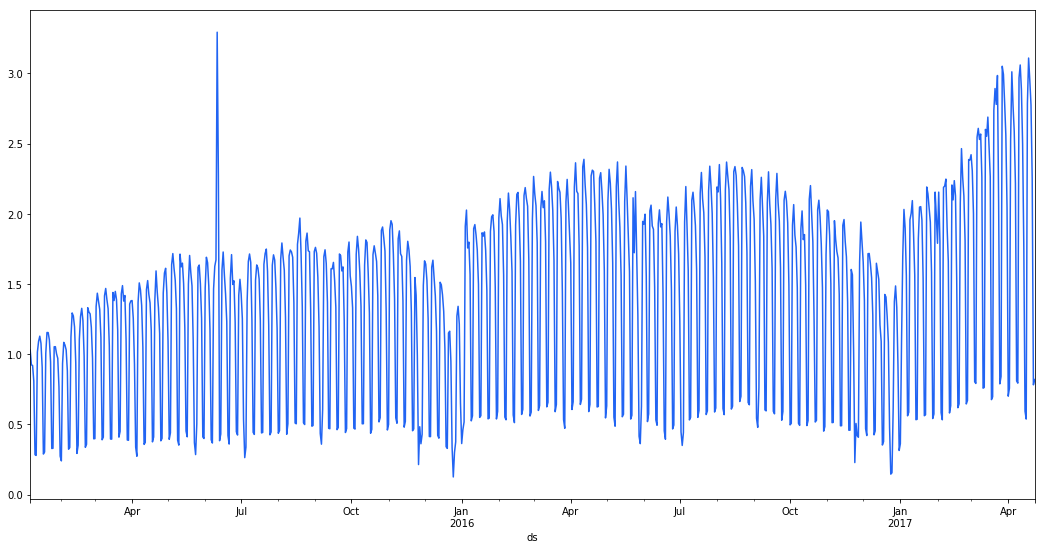

In [8]:
data.set_index('ds').y.plot(color=i_blue)

In [11]:
sigmas = 1.6
window = 91
t = data.y.rolling(window, )
data['r_upper'] = (t.mean() + sigmas * t.std())
data['r_lower'] = (t.mean() - sigmas * t.std())

In [12]:
data[data[['y', 'r_upper', 'r_lower']].median(axis=1) != data.y]

,ds,y,r_upper,r_lower
138,2015-05-24,0.285714,1.862643,0.333236
156,2015-06-11,3.292446,2.019009,0.259045
157,2015-06-12,2.278983,2.052789,0.252011
324,2015-11-26,0.214660,2.160759,0.371103
347,2015-12-19,0.341810,2.136703,0.346764
348,2015-12-20,0.329843,2.139007,0.341205
353,2015-12-25,0.126402,2.113184,0.275993
488,2016-05-08,0.487659,2.725175,0.534443
508,2016-05-28,0.415856,2.730245,0.515910
509,2016-05-29,0.363500,2.734367,0.506857


In [13]:
data['y_fix'] = data[['y', 'r_upper', 'r_lower']].median(axis=1)

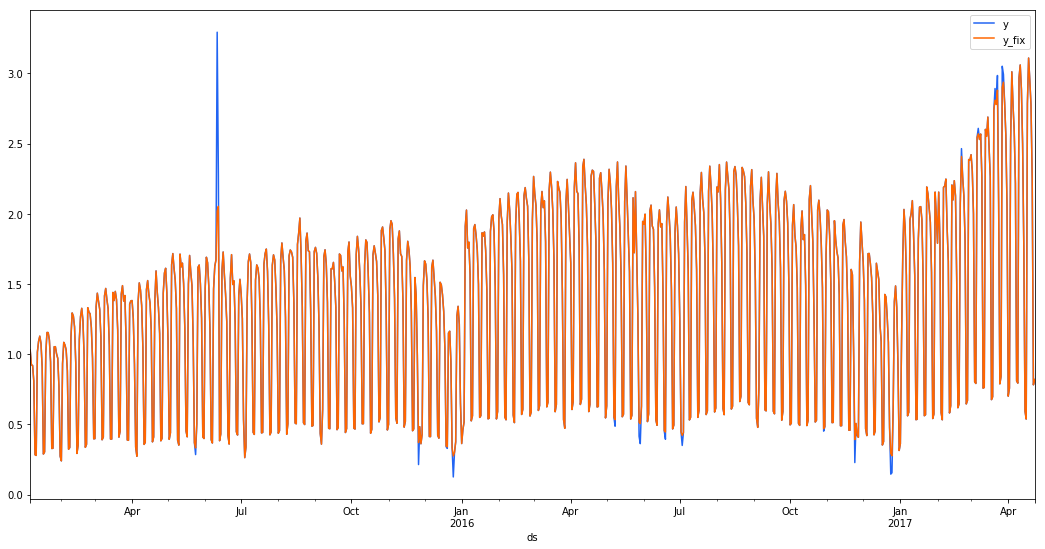

In [14]:
data.plot(x='ds', y=['y', 'y_fix'], color=[i_blue, i_orng])

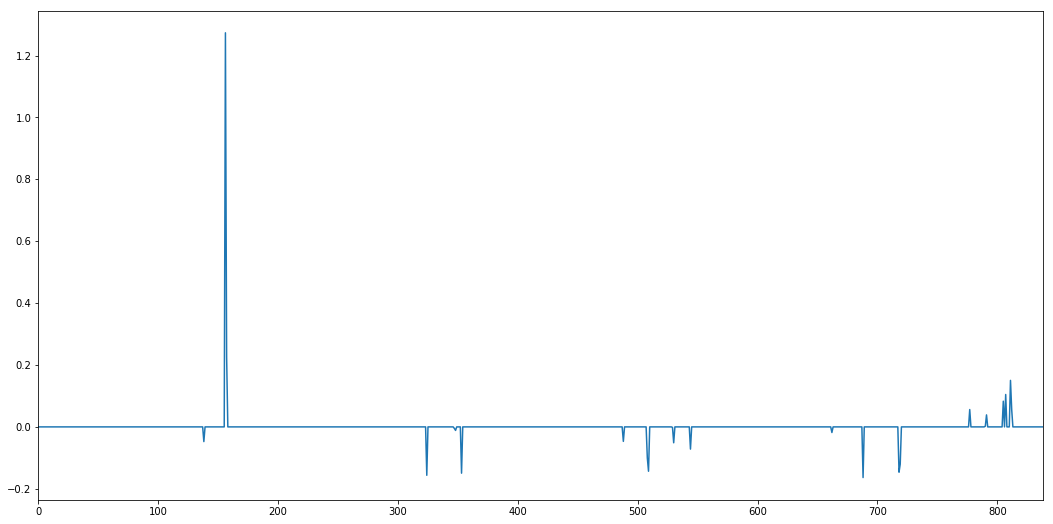

In [15]:
(data.y - data.y_fix).plot()

In [16]:
# only pre-intervention!!

data.loc[data.ds<intervention, 'y'] = data.loc[data.ds<intervention, 'y_fix']

In [20]:
model = Prophet(daily_seasonality=False)

In [21]:
model.fit(data[data.ds<intervention])

In [22]:
prediction = model.predict(data)

# 
prediction['y'] = data.y
prediction['effect'] = prediction.y - prediction.yhat

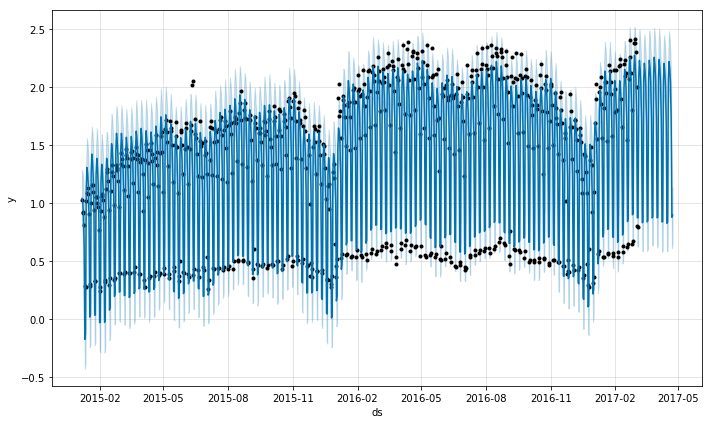

In [23]:
model.plot(prediction);

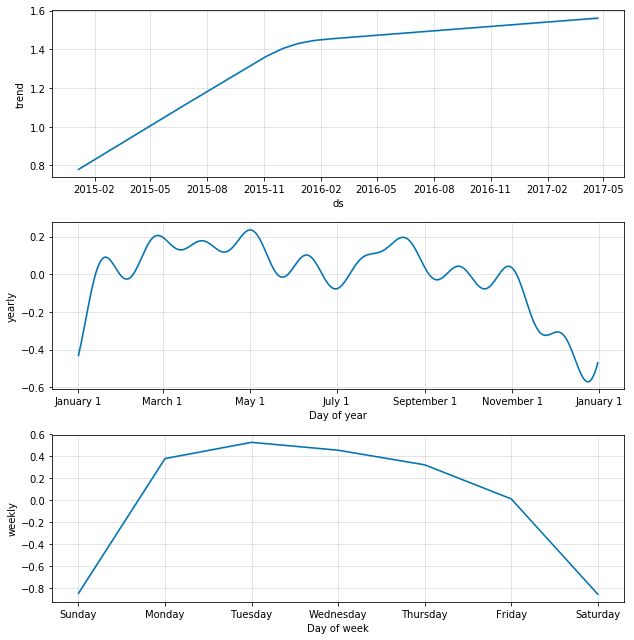

In [24]:
model.plot_components(prediction);

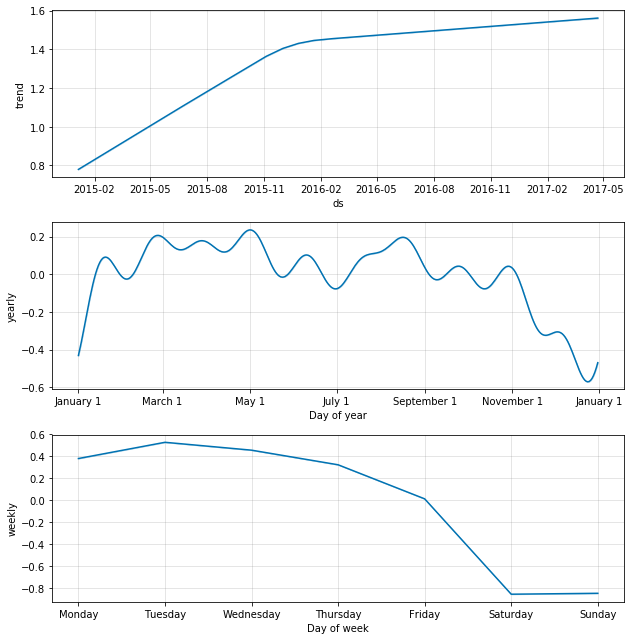

In [25]:
model.plot_components(prediction, weekly_start=1);

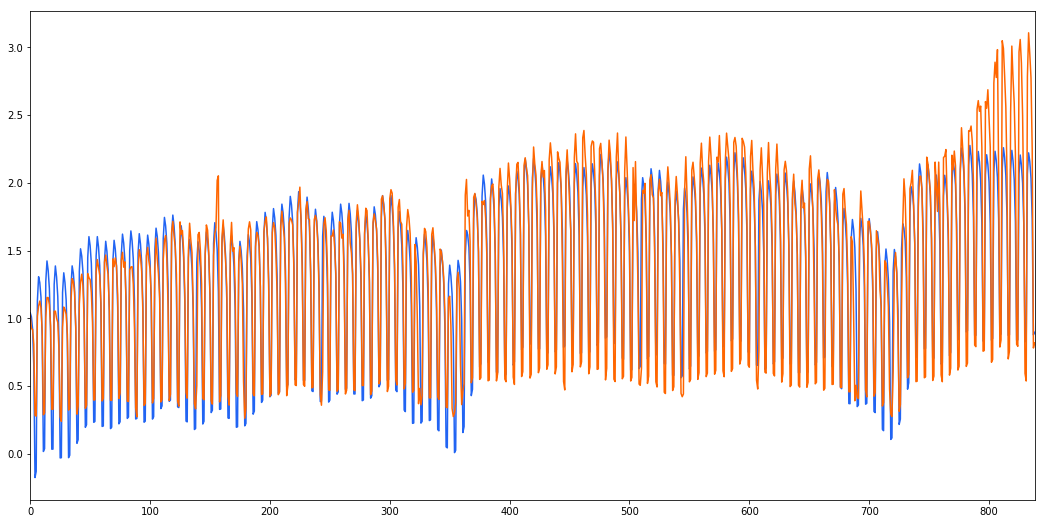

In [28]:
(prediction.trend + 1*prediction.yearly + 1*prediction.weekly).plot(color=i_blue)
prediction.y.plot(color=i_orng)

In [29]:
test_intervention = '2017-01-16'

In [30]:
test_model = Prophet(daily_seasonality=False)

In [31]:
test_model.fit(data[data.ds<test_intervention]);

In [32]:
test_prediction = test_model.predict(data)
test_prediction['y'] = data.y

In [33]:
test_prediction = test_prediction[(test_prediction.ds>=test_intervention) & (test_prediction.ds<intervention)].set_index('ds')

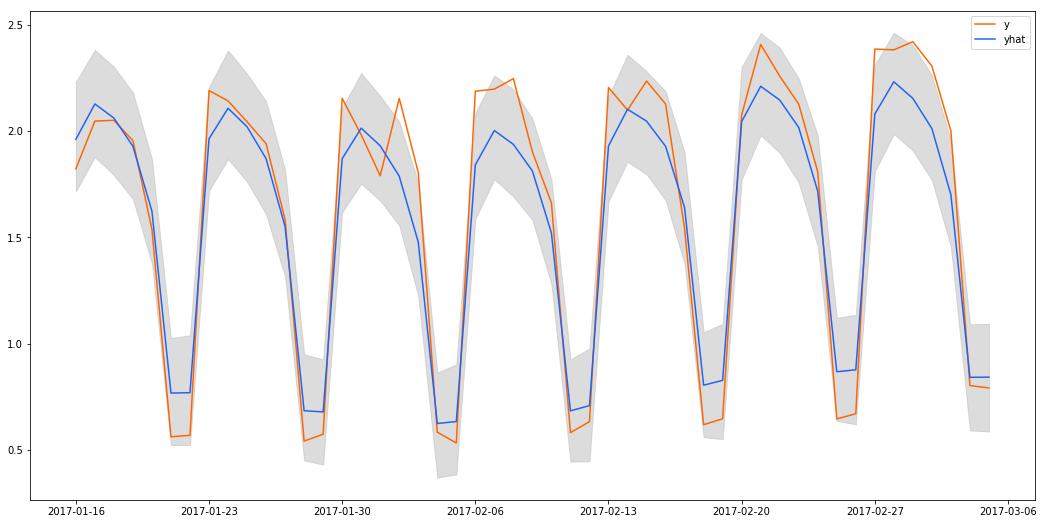

In [34]:
plot_me(test_prediction, i=None)

In [35]:
# H0: equal averages in samples
stats.ttest_ind(test_prediction.y, test_prediction.yhat)

Ttest_indResult(statistic=0.41241613122080589, pvalue=0.68095398303658083)

In [36]:
#p-value is big, we cannot reject H0 -> y and yhat have equal means

In [37]:
stats.ks_2samp(test_prediction.y, test_prediction.yhat)

Ks_2sampResult(statistic=0.24489795918367352, pvalue=0.089186492534720663)

In [38]:
forecast = prediction[prediction.ds>=intervention].set_index('ds')

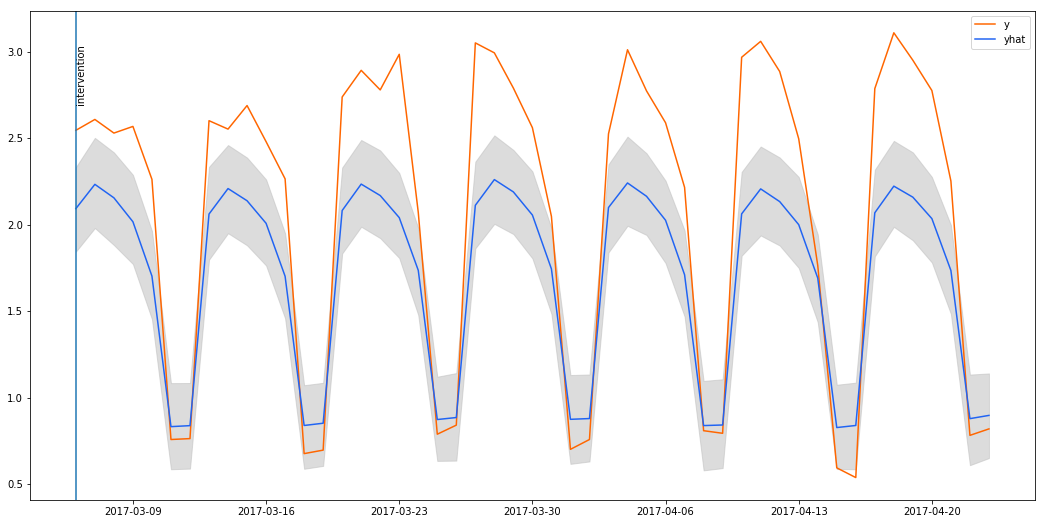

In [39]:
plot_me(forecast)

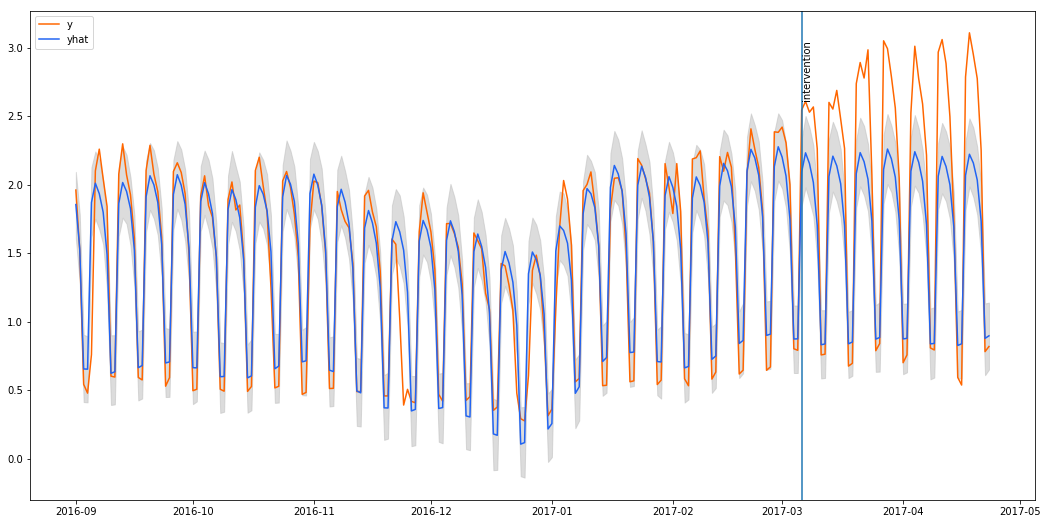

In [40]:
plot_me(prediction[prediction.ds>='2016-09-01'].set_index('ds'))

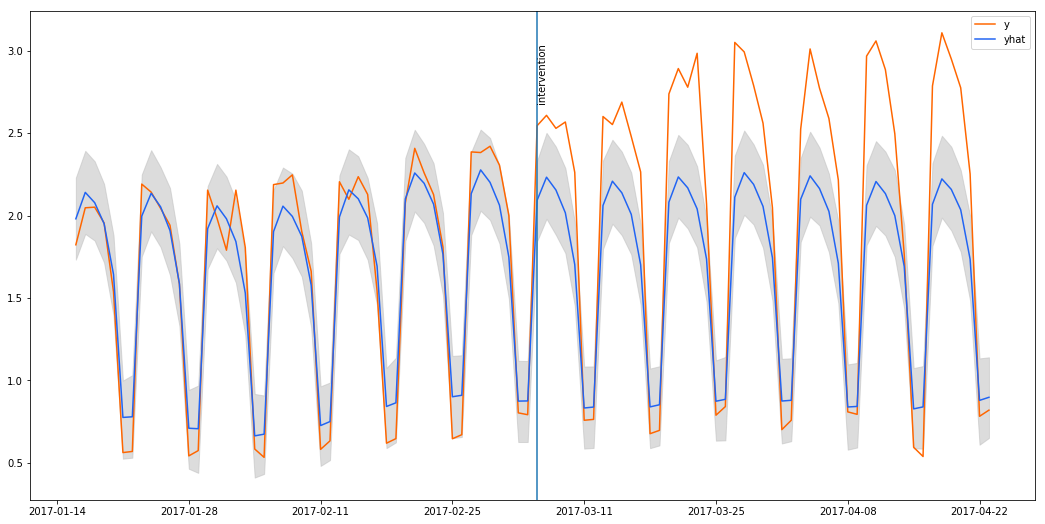

In [41]:
plot_me(prediction[prediction.ds>=test_intervention].set_index('ds'))

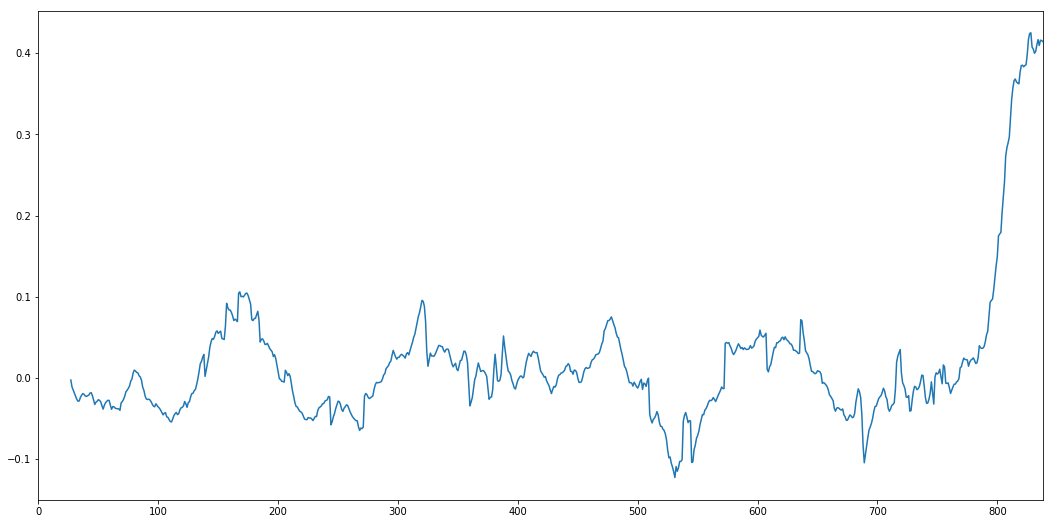

In [42]:
prediction.effect.rolling(28).mean().plot()

In [43]:
stats.ttest_ind(forecast.y, forecast.yhat)

Ttest_indResult(statistic=2.5404077569632126, pvalue=0.012676309878154842)

In [44]:
#p-value < 0.05 , we can reject H0 -> y and yhat DO NOT have equal means

In [45]:
stats.ks_2samp(forecast.y, forecast.yhat)

Ks_2sampResult(statistic=0.61224489795918369, pvalue=7.2310701357619696e-09)

In [46]:
sum(forecast.y) - sum(forecast.yhat)

18.987164107076524

In [47]:
100 * sum(forecast.y - forecast.yhat)/sum(forecast.yhat) # yes, yhat - this is uplift over predicted baseline

22.74178693433311

In [48]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [49]:
t = prediction[(prediction.ds<intervention) & (prediction.y.notnull())]

In [50]:
for x in [mean_squared_error, r2_score, mean_absolute_error]:
    print(x(t.y, t.yhat), x)

0.0381177785995 <function mean_squared_error at 0x1111087b8>
0.907117597972 <function r2_score at 0x1111089d8>
0.133217023828 <function mean_absolute_error at 0x111108730>


In [51]:
t = prediction[(prediction.ds>=intervention)]

for x in [mean_squared_error, r2_score, mean_absolute_error]:
    print(x(t.y, t.yhat), x)

0.28189811065 <function mean_squared_error at 0x1111087b8>
0.650868060964 <function r2_score at 0x1111089d8>
0.455920459333 <function mean_absolute_error at 0x111108730>


In [ ]:
plot_me(prediction[prediction.ds>='2016-09-01'].set_index('ds'))